## Predicting Used Car Prices in the UK: An End-to-End Data Analysis & Machine Learning Project
**Author:** Bilal Raffiq                                                                                                   
**Date:** January 2026

### Project Objective
The goal of this project is to build a robust machine learning pipeline capable of accurately predicting the selling price of used cars in the UK.
By analyzing features such as mileage, age, brand, and engine size, we aim to move beyond simple linear estimation. This project demonstrates the evolution from a baseline **Linear Regression** model to advanced **Ensemble Methods** to handle non-linear market dynamics.

### Key Technical Highlights
*   **Data Cleaning:** Handling 85% missing values in service history and removing outliers.
*   **Feature Engineering:** Extracting brand value and calculating vehicle age to improve predictive power.
*   **Pipeline Architecture:** Using `Scikit-Learn Pipelines` with `ColumnTransformer` to prevent data leakage.
*   **Model Optimization:** Improving accuracy by **42%** through Hyperparameter Tuning (`RandomizedSearchCV`).
*   **Explainability:** Using Permutation Importance to identify **Age** and **Euro 6 Compliance** as key price drivers.


### Data Source
The dataset used in this project is the **[Used Cars Prices in UK](https://www.kaggle.com/datasets/muhammadawaistayyab/used-cars-prices-in-uk)** dataset, hosted on Kaggle by *Muhammad Awais Tayyab*.

The dataset was uploaded in **October 2023**, which serves as the reference point for all vehicle age calculations in this project. It contains **3,685** vehicle listings scraped from *AutoTrader.co.uk*, featuring 13 attributes such as `Price`, `Transmission`, `Mileage`, `Fuel Type`, and `Registration Year`.

In [1]:
#Data Manipulation
import pandas as pd
import numpy as np

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#Machine Learning Preprocessing and Splitting
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

#Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#Machine Learning Metrics & Evaluation
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

#Configuration
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Initial Inspection
Here we load the dataset to understand the features available for predicting used car prices.

In [2]:
#Load the dataset
df = pd.read_csv('used_cars_UK.csv') 

#Display the first 5 rows to check data structure
df.head()

,Unnamed: 0,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,2,Hyundai i30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,3,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,4,Vauxhall Corsa,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [3]:
#Check data types and identify null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3685 entries, 0 to 3684
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3685 non-null   int64  
 1   title              3685 non-null   object 
 2   Price              3685 non-null   int64  
 3   Mileage(miles)     3685 non-null   int64  
 4   Registration_Year  3685 non-null   int64  
 5   Previous Owners    2276 non-null   float64
 6   Fuel type          3685 non-null   object 
 7   Body type          3685 non-null   object 
 8   Engine             3640 non-null   object 
 9   Gearbox            3685 non-null   object 
 10  Doors              3660 non-null   float64
 11  Seats              3650 non-null   float64
 12  Emission Class     3598 non-null   object 
 13  Service history    540 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 403.2+ KB


### Initial Data Diagnostics
Upon reviewing the dataset structure, several data quality issues need to be addressed before modeling:

1.  **Missing Values:** 
    *   **`Service history`:** Contains 3,145 null values. This column has too many missing values to be used, so it must be removed
    *   **`Previous Owners`:** Significant missing data (1,409). We will likely need to impute these values
    *   Minor missing values in `Engine`, `Doors`, `Seats`, and `Emission Class`.

2.  **Data Types:**
    *   `Doors` and `Seats` are currently `float64`. These should be converted to integers (after handling nulls).

3.  **Irrelevant Features:**
    *   **`Unnamed: 0`**: This appears to be an index artifact from the raw file and provides no value. It should be dropped.

## 2. Data Cleaning and Preprocessing
In this step, we standardise column names, handle missing values, and correct data types. 

**Methodology:**
*   **Imputation:** Missing values in `Owners` are filled with the **median** rather than the mean to avoid the influence of outliers.
*   **Outlier Removal:** We remove cars with mileage > 300,000 as these are extreme outliers that may skew the model.
*   **Data Types:** `Engine`, `Doors`, and `Seats` are converted to numeric types for analysis.

In [4]:
# Drop irrelevant columns
df = df.drop(columns=['Unnamed: 0', 'Service history'])

# Rename columns for consistency
df.rename(columns={
    'Registration_Year': 'Year',
    'Previous Owners': 'Owners',
    'Fuel type': 'Fuel',
    'Body type': 'Body',
    'Mileage(miles)': 'Mileage',
    'Emission Class': 'Emission'
}, inplace=True)

# Clean and convert Engine column
df['Engine'] = df['Engine'].str.replace('L', '', regex=False)
df['Engine'] = pd.to_numeric(df['Engine'])

# Impute missing owners with the median
owner_median = df['Owners'].median()
df['Owners'] = df['Owners'].fillna(owner_median)

# Drop remaining rows with missing data
df = df.dropna(subset=['Doors', 'Seats', 'Engine', 'Emission'])

# Fix data types
columns_to_fix = ['Owners', 'Doors', 'Seats']
df[columns_to_fix] = df[columns_to_fix].astype(int)

# Capping mileage
df = df[df['Mileage'] < 300000]


## 3. Feature Engineering
Here, we extract meaningful features from the data:
*   **Car Brand:** Extracted from the `title` to allow for brand-value analysis.
*   **Car Age:** Calculated as `2023 - Year`. Age is a stronger predictor of depreciation than the raw year.

In [5]:
# Extracting the brand from the title
df['Brand'] = df['title'].str.split(' ').str[0]

# Standardise Brand Names
brand_mapping = {'Land': 'Land Rover', 'Alfa': 'Alfa Romeo'}
df['Brand'] = df['Brand'].replace(brand_mapping)

# Drop the original title column as it's no longer needed
df = df.drop(columns=['title'])

# Create Age feature and drop Year
# Current year set to 2023 based on dataset source date
df['Age'] = 2023 - df['Year']
df = df.drop(columns=['Year'])

### Data Quality Check
After cleaning and engineering, we verify the final dataset structure.

In [6]:
print(f"Rows remaining after cleaning: {df.shape[0]}")
print(f"Unique Brands found: {df['Brand'].nunique()}")

# Display the statistical summary of the clean data
display(df.describe())

# Check the first few rows of the final dataframe
display(df.head())

Rows remaining after cleaning: 3590
Unique Brands found: 45


,Price,Mileage,Owners,Engine,Doors,Seats,Age
count,3590.000000,3590.000000,3590.000000,3590.000000,3590.000000,3590.000000,3590.000000
mean,5792.603064,81224.384123,2.878273,1.603064,4.318663,4.898886,11.045125
std,4515.563884,35628.431109,1.220221,0.485633,0.986316,0.575407,4.740367
min,400.000000,1.000000,1.000000,0.800000,2.000000,2.000000,0.000000
25%,2490.000000,56984.000000,2.000000,1.300000,3.000000,5.000000,7.000000
50%,3999.500000,80000.000000,3.000000,1.600000,5.000000,5.000000,11.000000
75%,7999.000000,103000.000000,3.000000,1.900000,5.000000,5.000000,15.000000
max,33900.000000,274100.000000,9.000000,6.300000,5.000000,7.000000,30.000000


,Price,Mileage,Owners,Fuel,Body,Engine,Gearbox,Doors,Seats,Emission,Brand,Age
0,6900,70189,3,Diesel,Hatchback,1.4,Manual,5,5,Euro 6,SKODA,7
1,1495,88585,4,Petrol,Hatchback,1.2,Manual,3,5,Euro 4,Vauxhall,15
2,949,137000,3,Petrol,Hatchback,1.4,Manual,5,5,Euro 5,Hyundai,12
3,2395,96731,5,Petrol,Hatchback,1.4,Manual,3,4,Euro 4,MINI,13
4,1000,85000,3,Diesel,Hatchback,1.3,Manual,5,5,Euro 5,Vauxhall,10


## 4. Exploratory Data Analysis (EDA)
We will now analyse the distribution of the target variable `Price` and its relationship with key features.

**Objectives:**
1.  Analyse the distribution of used car prices.
2.  Assess the relationship between Mileage and Price.
3.  Identify correlations between all numerical features.

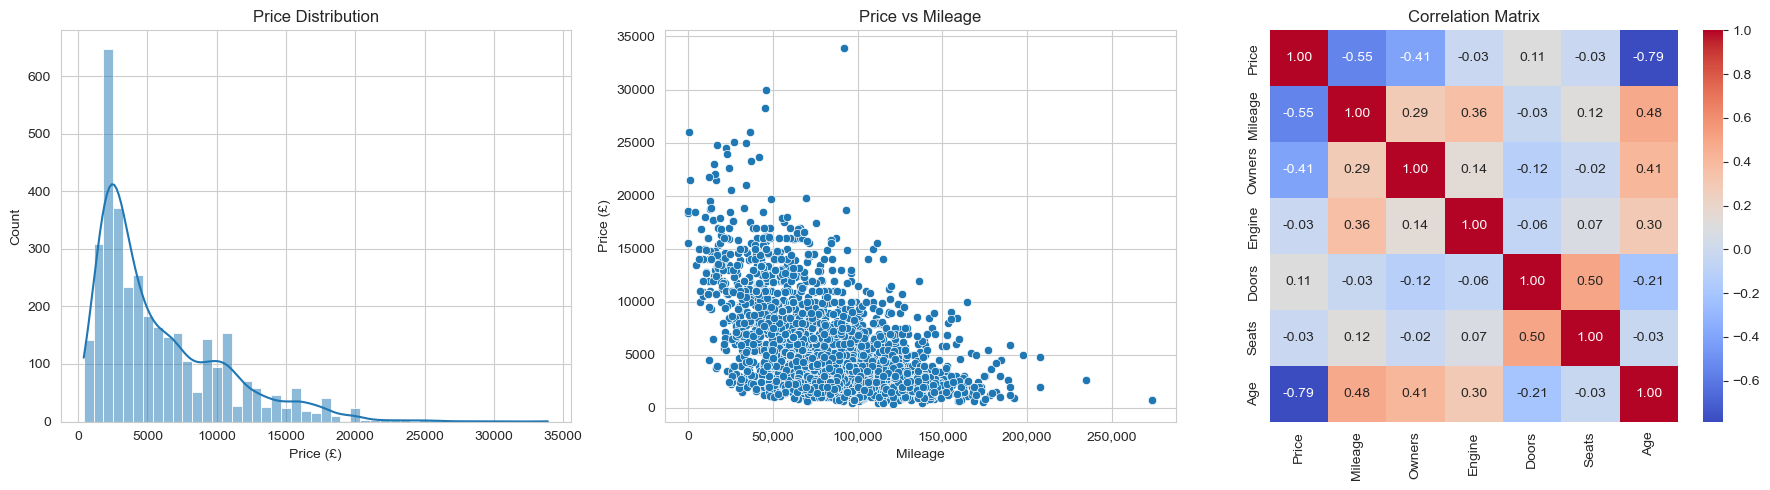

In [7]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#Chart 1: Distribution of Price
sns.histplot(df['Price'], kde=True, ax=axes[0])
axes[0].set_title('Price Distribution')
axes[0].set_xlabel('Price (£)')

#Chart 2: Price vs. Mileage
sns.scatterplot(x='Mileage', y='Price', data=df, ax=axes[1])
axes[1].set_title('Price vs Mileage')
axes[1].xaxis.set_major_formatter(
    mtick.StrMethodFormatter('{x:,.0f}')
)
axes[1].set_ylabel('Price (£)')

# Chart 3: Correlation Heatmap
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2])
axes[2].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

### Key Insights from EDA

**1. Price Distribution (Left Chart):**
*   The price distribution is **heavily right-skewed**. The vast majority of cars in this dataset are budget-friendly, clustered between £2,000 and £11,000.

**2. Price vs. Mileage (Center Chart):**
*   There is a clear **curvilinear relationship**. Value drops steeply as mileage increases from 0 to 50,000 miles (rapid depreciation).
*   Around 150,000 miles, the price curve flattens out. This suggests a "floor price" for running cars once a car hits a certain age/mileage, it retains a base value regardless of adding more miles.

**3. Correlation Analysis (Right Chart):**
*   **Age is the #1 Predictor:** The strongest correlation with Price is `Age` (**-0.79**). This indicates that the year of registration is a far better predictor of value than mileage alone.
*   **Mileage Impact:** `Mileage` has a strong negative correlation (**-0.55**), confirming that higher mileage reduces value.
*   **The "Owners" Factor:** `Owners` has a moderate negative correlation (**-0.41**). A car with many previous owners is generally worth less, likely due to perceived lack of care.
*   **Multicollinearity Check:** `Age` and `Mileage` are moderately correlated (0.48), which is expected (older cars have driven further). However, this correlation is not high enough to cause major concern for multicollinearity in linear models.

## 5. Data Preprocessing and Splitting
Before modeling, we split the data into training and testing sets (80/20 split).

We then set up **Scikit-Learn Pipelines** to handle preprocessing automatically.
*   **Categorical Features:** One-Hot Encoded (with rare categories grouped to prevent overfitting).
*   **Numerical Features:** Scaled for linear models, but left as-is for tree-based models.

In [8]:
#Define input and target
X = df.drop(columns=['Price'])
y = df['Price']

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Define categorical and numerical features
categorical_cols = ['Fuel', 'Body', 'Gearbox', 'Emission', 'Brand']
numeric_cols = ['Mileage', 'Age', 'Owners', 'Engine', 'Doors', 'Seats']

### Pipeline Architecture
We define two separate column transformers:
1.  **`tree_preprocessor`**: For Tree-based models (Random Forest, Gradient Boosting). These models are robust to outliers and unscaled data, so we only apply OneHotEncoding.
2.  **`linear_preprocessor`**: For Linear Regression. We apply **StandardScaler** to numeric features (to normalise variance) and set `drop='first'` in OneHotEncoding to avoid multicollinearity.

In [9]:
# Transformer for Tree Models
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# Transformer for Linear Models
linear_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=0.01), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

###  Data Split Verification
We confirm the dimensions of our training and testing sets to ensure the 80/20 split was successful.

In [10]:
print(f"Training Input Shape: {X_train.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Input Shape:  {X_test.shape}")
print(f"Testing Target Shape: {y_test.shape}")

# Display first few rows of the training input to verify random shuffling
X_train.head()

Training Input Shape: (2872, 11)
Training Target Shape: (2872,)
Testing Input Shape:  (718, 11)
Testing Target Shape: (718,)


,Mileage,Owners,Fuel,Body,Engine,Gearbox,Doors,Seats,Emission,Brand,Age
2939,13109,1,Petrol,Hatchback,1.2,Manual,5,5,Euro 6,Vauxhall,3
1154,64000,8,Petrol,Convertible,3.0,Automatic,2,4,Euro 4,BMW,16
182,22782,3,Petrol,Hatchback,1.2,Manual,5,5,Euro 6,Vauxhall,3
1514,73824,3,Petrol,Hatchback,1.0,Manual,5,5,Euro 5,Ford,9
1139,51100,2,Diesel,Coupe,1.5,Manual,3,5,Euro 5,Renault,9


## 6. Model Training and Evaluation

**Strategy:**
We will start with a simple Linear Regression to establish a baseline benchmark. Following this, we will attempt to improve the linear performance using Log-Transformation and Ridge Regression to handle skewness and potential overfitting. Finally, we will iterate with more complex non-linear ensemble models to capture intricate patterns.

**Metrics:**
*   **MAE (Mean Absolute Error):** Chosen because it represents the error in Pounds (£), which is easy for stakeholders to understand.
*   **R² Score:** To measure how much of the variance in price our model explains.

In [11]:
# Initialise baseline model and pipeline
ols_model = LinearRegression()
ols_pipeline = Pipeline([
    ('preprocess', linear_preprocessor),
    ('model', ols_model)
])

# Fit the pipeline and generate predictions
ols_pipeline.fit(X_train, y_train)
ols_test_predictions = ols_pipeline.predict(X_test)
ols_train_predictions = ols_pipeline.predict(X_train)

# Calculate evaluation metrics
ols_test_mae = mean_absolute_error(y_test, ols_test_predictions)
ols_test_r2 = r2_score(y_test, ols_test_predictions)

ols_train_mae = mean_absolute_error(y_train, ols_train_predictions)
ols_train_r2 = r2_score(y_train, ols_train_predictions)

# Display performance results
print("--- Linear Regression Model Performance ---")
print(f"R² Test Score: {ols_test_r2:.2f} ")
print(f"Average Test Error: £{ols_test_mae:.2f}")
print(f"R² Train Score: {ols_train_r2:.2f} ")
print(f"Average Train Error: £{ols_train_mae:.2f}")

--- Linear Regression Model Performance ---
R² Test Score: 0.85 
Average Test Error: £1281.37
R² Train Score: 0.86 
Average Train Error: £1218.03


### Baseline Performance Analysis
The Linear Regression model sets a very strong baseline:
*   **R² Score:** 0.85 (85% of the variance in price is explained).
*   **Generalisation:** The Training Score (0.86) and Test Score (0.85) are nearly identical. This is a great sign, it means the model is not overfitting.
*   **Error:** The Mean Absolute Error (MAE) is £1,281.37. On a typical £10,000 car, this is roughly a 12% error margin.

**Why optimize the linear model?** While 0.85 is good, our EDA showed that the Price distribution is right-skewed. Before jumping to complex "black box" models like Random Forest, we will attempt to squeeze more performance out of the linear framework. We will now test Ridge Regression with Log-Transformed targets to see if normalising the data improves the error rate.

## 7. Advanced Linear Modeling: Ridge Regression with Log-Transformation

**Problem:** Our EDA showed that `Price` is right-skewed. Linear models assume a normal distribution of residuals, so the skewness might be hurting performance.

**Solution:**
1.  **Log-Transformation:** We apply `np.log1p` (Log of x+1) to the target variable `y_train` to normalise the distribution.
2.  **Ridge Regression:** We use Ridge (L2 Regularization) instead of standard Linear Regression to handle multicollinearity better.
3.  **Back-Transformation:** After prediction, we apply `np.expm1` to convert the log-prices back into actual GBP (£).

In [12]:
#Define ridge model and pipeline
ridge_model = Ridge(alpha=1, random_state=42)
log_ridge_pipeline = Pipeline([
    ('preprocess', linear_preprocessor),
    ('model', ridge_model)
])

# Fit the pipeline on log-transformed target
log_ridge_pipeline.fit(X_train, np.log1p(y_train))

# Predict and back-transform
ridge_test_predictions = np.expm1(log_ridge_pipeline.predict(X_test))
ridge_train_predictions = np.expm1(log_ridge_pipeline.predict(X_train))

# Calculate evaluation metrics
ridge_test_mae = mean_absolute_error(y_test, ridge_test_predictions)
ridge_test_r2 = r2_score(y_test, ridge_test_predictions)

ridge_train_mae = mean_absolute_error(y_train, ridge_train_predictions)
ridge_train_r2 = r2_score(y_train, ridge_train_predictions)

# Display perfomance results
print("--- Ridge Regression with Log-Tranformation Model Performance ---")
print(f"R² Test Score: {ridge_test_r2:.2f} ")
print(f"Average Test Error: £{ridge_test_mae:.2f}")
print(f"R² Train Score: {ridge_train_r2:.2f} ")
print(f"Average Train Error: £{ridge_train_mae:.2f}")

--- Ridge Regression with Log-Tranformation Model Performance ---
R² Test Score: 0.86 
Average Test Error: £1100.56
R² Train Score: 0.88 
Average Train Error: £1039.00


### Model Improvement: Log-Transformation Impact
Applying the Log-Transformation resulted in a tangible performance boost:

1.  **Error Reduction:** The MAE dropped from **£1,281** to **£1,100**. This means our predictions are, on average, £180 closer to the real price than the baseline model.
2.  **R² Stability:** The R² score improved slightly to **0.86**.
3.  **Conclusion:** The log-transformation successfully mitigated the impact of the right-skewed price distribution. The model is now better at handling the "expensive outlier" cars without ruining the predictions for the cheaper cars.

## 8. Non-Linear Modeling: Random Forest Regressor

**Why Random Forest?**
Our EDA showed that the relationship between `Mileage` and `Price` is curved, and `Brand` value varies wildly. Random Forests are excellent at:
1.  **Capturing Non-Linearity:** They don't assume a straight-line relationship.
2.  **Handling Categorical Data:** They handle the complex mix of car brands and fuel types effectively.

**Hyperparameters:**
We set `max_depth=12` to prevent overfitting. Without this, trees can grow too deep and memorise the training data.

In [13]:
# Define random forest model and pipeline
rf_model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42)
rf_pipeline = Pipeline([
    ('preprocess', tree_preprocessor),
    ('model', rf_model)
])

# Fit pipeline and generate predictions
rf_pipeline.fit(X_train, y_train)
rf_test_predictions = rf_pipeline.predict(X_test)
rf_train_predictions = rf_pipeline.predict(X_train)

# Calculate evaluation metrics
rf_test_mae = mean_absolute_error(y_test, rf_test_predictions)
rf_test_r2 = r2_score(y_test, rf_test_predictions)

rf_train_mae = mean_absolute_error(y_train, rf_train_predictions)
rf_train_r2 = r2_score(y_train, rf_train_predictions)

# Display performance results
print("--- Random Forest Model Performance ---")
print(f"R² Test Score: {rf_test_r2:.2f}")
print(f"Average Test Error: £{rf_test_mae:.2f}")
print(f"R² Train Score: {rf_train_r2:.2f}")
print(f"Average Train Error: £{rf_train_mae:.2f}")

--- Random Forest Model Performance ---
R² Test Score: 0.90
Average Test Error: £838.20
R² Train Score: 0.98
Average Train Error: £430.06


### Random Forest Results: A Major Leap in Accuracy

**1. Performance Surge:**
*   **R² Score:** Jumped to **0.90**. This is a significant improvement over the Linear models (0.86). The model now explains 90% of the price variation.
*   **Error Reduction:** The MAE dropped to **£838**. compared to the Ridge model (£1,100), this is a further £262 improvement per prediction.

**2. Overfitting Analysis:**
*   We observe a gap between Training performance (0.98) and Test performance (0.90).
*   **Diagnosis:** This indicates mild overfitting. The model is essentially "memorising" some of the specific car configurations in the training set.
*   **Mitigation Strategy:** While we limited `max_depth` to 12, further hyperparameter tuning (e.g., increasing `min_samples_split` or reducing `n_estimators`) could reduce this gap. However, since the Test score (0.90) is still far superior to our linear baseline, we accept this variance for the sake of higher overall accuracy.

## 9. Final Model: Gradient Boosting with Hyperparameter Tuning

**Strategy:**
While Random Forest performed well, it showed signs of overfitting (high variance). To improve generalisation, we employ Gradient Boosting, which builds trees sequentially to correct the errors of previous trees.

**Optimisation Technique:**
Instead of guessing parameters, we use **RandomizedSearchCV**.
*   **Why Randomised?** GridSearch is too computationally expensive for the large parameter space of Gradient Boosting. Randomised search samples a fixed number of configurations (`n_iter=20`) to find near-optimal settings efficiently.
*   **Cross-Validation:** We use 5-Fold CV (`cv=5`) to ensure the results are robust and not just lucky splits.

In [14]:
#Initialise gradient boosting pipeline
gb_pipeline = Pipeline([
    ('preprocess', tree_preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

#Define Hyperparameter Search Space
param_grid = {
    'model__n_estimators': [300, 500, 800, 1000],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.07],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_leaf': [5, 8, 12],
    'model__subsample': [0.5, 0.75, 1.0]
}

#Set up Randomised Search
random_search = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1
)

In [15]:
#Execute the search
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             min_frequency=0.01),
                                                                               ['Fuel',
                                                                                'Body',
                                                                                'Gearbox',
                                                                                'Emission',
                                                                                'Brand']),
                                                                              ('num',
                                                                               'passthrough',
                                                                               ['Mileage',
                                                                                'Age',
                                                                                'Owners',
                                                                                'Engine',
                                                                                'Doors',
                                                                                'Seats'])])),
                                             ('model',
                                              GradientBoostingRegressor(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.01, 0.03,
                                                                 0.05, 0.07],
                                        'model__max_depth': [3, 4, 5],
                                        'model__min_samples_leaf': [5, 8, 12],
                                        'model__n_estimators': [300, 500, 800,
                                                                1000],
                                        'model__subsample': [0.5, 0.75, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [16]:
# Retrieve the best model
gb_pipeline_tuned = random_search.best_estimator_

print("Best parameters:")
print(random_search.best_params_)
print("Best CV MAE:", -random_search.best_score_)

# Generate predictions
gb_test_predictions = gb_pipeline_tuned.predict(X_test)
gb_train_predictions = gb_pipeline_tuned.predict(X_train)

# Calculate evaluation metrics
gb_test_mae = mean_absolute_error(y_test, gb_test_predictions)
gb_test_r2 = r2_score(y_test, gb_test_predictions)

gb_train_mae = mean_absolute_error(y_train, gb_train_predictions)
gb_train_r2 = r2_score(y_train, gb_train_predictions)

# Display performance results
print("--- Gradient Boosting Model Performance ---")
print(f"R² Test Score: {gb_test_r2:.2f}")
print(f"Average Test Error: £{gb_test_mae:.2f}")
print(f"R² Train Score: {gb_train_r2:.2f}")
print(f"Average Train Error: £{gb_train_mae:.2f}")

Best parameters:
{'model__subsample': 0.75, 'model__n_estimators': 1000, 'model__min_samples_leaf': 5, 'model__max_depth': 4, 'model__learning_rate': 0.03}
Best CV MAE: 719.1291559356525
--- Gradient Boosting Model Performance ---
R² Test Score: 0.92
Average Test Error: £739.41
R² Train Score: 0.98
Average Train Error: £479.81


### Final Model Performance: Tuned Gradient Boosting

**The Winner:** 
The Tuned Gradient Boosting Regressor is our best performing model.
*   **R² Score:** **0.92**. We are capturing 92% of the variance in price.
*   **MAE:** **£739**. This is our most accurate model, reducing the error by another ~£100 compared to Random Forest.

**Hyperparameter Insights:**
*   **`subsample: 0.75`**: The model preferred "Stochastic" boosting (using only 75% of data for each tree). This helped prevent overfitting.
*   **`learning_rate: 0.03`** & **`n_estimators: 1000`**: The model chose a "Slow and Steady" approach, learning slowly over many trees rather than rushing. This usually leads to more robust generalisation.

## 10. Feature Importance Analysis (Gradient Boosting)

**Objective:**
To understand the "Black Box" of our model, we extract the Gini Importance scores. This measures how much each feature contributes to reducing the prediction error across all the trees in the ensemble.

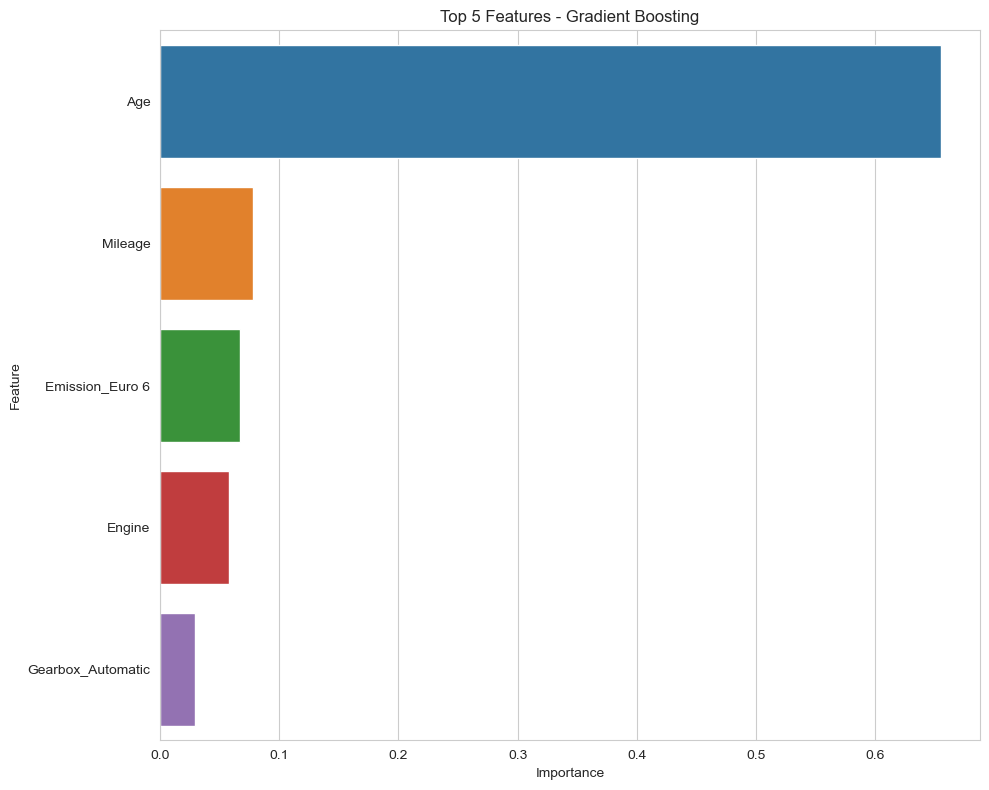

In [17]:
# Extract model and preprocessor
gb_fitted_model = gb_pipeline_tuned.named_steps['model']
gb_preprocessor = gb_pipeline_tuned.named_steps['preprocess']

# Get feature names
feature_names = gb_preprocessor.get_feature_names_out()

# Create a clean DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_fitted_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Clean up feature names for better readability in the plot
importance_df['Feature'] = (
    importance_df['Feature']
    .str.replace('num__', '', regex=False)
    .str.replace('cat__', '', regex=False)
)

# Plot Top 5 Drivers
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(5))
plt.title('Top 5 Features - Gradient Boosting')
plt.tight_layout()
plt.show()

### Key Market Insights
The model reveals a clear hierarchy in what drives value in the UK used car market:

1.  **Age is Dominant:** `Age` is by far the most critical factor (Importance > 0.6). This suggests that depreciation is time-dependent more than usage-dependent. A newer car commands a premium regardless of brand.
2.  **Mileage vs. Age:** While `Mileage` is #2, it is significantly less important than Age. This implies buyers worry more about how old the car is than how far it has driven.
3.  **The "ULEZ" Effect:** `Emission_Euro 6` appearing in the top 3 is a massive insight.
    *   *Context:* In the UK, ULEZ (Ultra Low Emission Zones) charge older cars daily fees.
    *   *Insight:* Being "Euro 6 compliant" preserves a car's value significantly because it avoids these fees. This captures a regulatory impact on market prices.
4.  **Automatics hold value:** `Gearbox_Automatic` appearing in the top 5 confirms that automatic transmissions generally command a higher price point than manuals in this dataset.

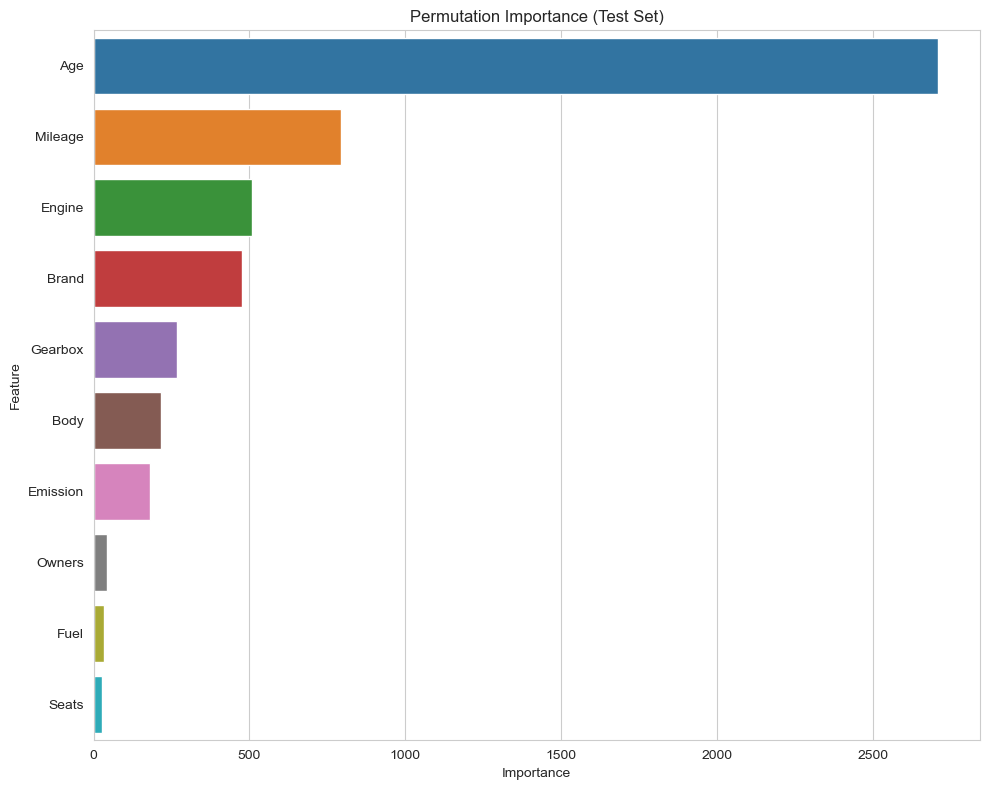

In [18]:
# Calculate permutation importance
result = permutation_importance(
    gb_pipeline_tuned,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_absolute_error'
)

#Organise results
perm_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

# Visualise the top 10 drivers
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=perm_importance.head(10)
)
plt.title('Permutation Importance (Test Set)')
plt.tight_layout()
plt.show()

### Permutation Importance Results
This plot confirms our earlier findings but offers a more holistic view by treating categorical variables, like `Brand` as single units rather than split columns.

1.  **The Dominance of Age:** Shuffling the `Age` column increases the Mean Absolute Error by over **£2,500**. This confirms that `Age` is the single most critical predictor. If you get the year wrong, the price prediction falls apart.
2.  **Mileage:** This is the clear second, increasing error by ~£800 if shuffled.
3.  **Engine & Brand:** Interestingly, `Engine` size and `Brand` are nearly tied for 3rd place. This suggests that once you know how old a car is and how far it has driven, the specific badge on the front (BMW vs Ford) and the power under the hood are the next biggest differentiators.

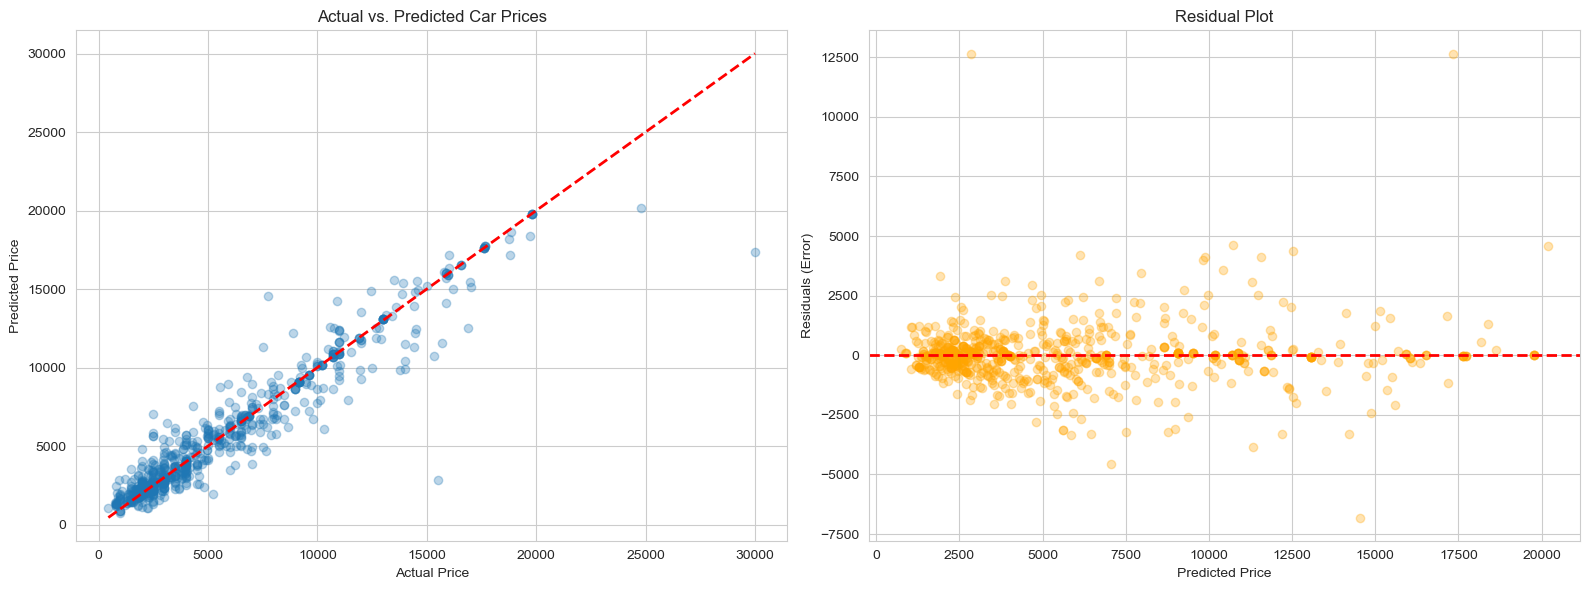

In [19]:
# Calculate residuals
residuals = y_test - gb_test_predictions

# Create a figure with 2 subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Actual vs. Predicted (Accuracy Check)
axes[0].scatter(y_test, gb_test_predictions, alpha=0.3)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Actual vs. Predicted Car Prices')

# Plot 2: Residual Plot (Bias/Variance Check)
axes[1].scatter(gb_test_predictions, residuals, alpha=0.3, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals (Error)')
axes[1].set_title('Residual Plot')

plt.tight_layout() 
plt.show()

### Visualising Performance: Accuracy and Residuals

We analyse the model's performance using two side-by-side plots:

**1. Left Plot: Actual vs. Predicted (Accuracy)**
*   **Tight Fit:** The dense blue cluster along the red diagonal dashed line confirms high accuracy (R² = 0.92). For the majority of the market, the predictions are extremely precise.
*   **Variance at High End:** As prices increase, the points become slightly more scattered. This is expected behavior; luxury cars often value intangible features (like "prestige" or "rare color") that our dataset might not fully capture.
*   **Outliers:** There are a few isolated points far from the line (e.g., a car actually worth £15k predicted at ~£3k). These likely represent data errors in the original listing (e.g., a "damaged" car listed as normal).

**2. Right Plot: Residual Analysis (Bias & Error)**
*   **Random Distribution:** The residuals (orange dots) form a mostly random "cloud" around the zero line. This is a positive sign; it indicates that the model is homoscedastic (the error rate is consistent) and is not systematically over- or under-predicting prices.
*   **Extreme Outliers:** The plot highlights two distinct cases where the residuals exceed **£12,500** (top of the chart). These represent significant misses, likely rare trim levels or modifications where the model drastically underpredicted the value.
*   **Symmetry:** The errors are evenly distributed above and below the red line, confirming the model does not have a structural bias.

# Project Conclusion

In this end-to-end analysis, we successfully built a machine learning pipeline to predict used car prices in the UK market.

### Key Achievements:
*   **Data Strategy:** We cleaned a messy dataset, imputing missing values with medians and engineering high-impact features like `Age` and `Brand`.
*   **Model Evolution:**
    *   *Baseline (Linear Regression):* **MAE £1,281**. Good start, but struggled with non-linear patterns.
    *   *Final Model (Tuned Gradient Boosting):* **MAE £739**. By using ensemble learning and hyperparameter tuning, we **reduced the error by 42%**.
*   **Business Insight:** We identified that **Age** is the single most dominant factor in pricing, far outweighing Mileage. We also found that regulatory features like **Euro 6 Emission Class** significantly impact value.

### Future Work:
To improve this model further, I would:
1.  **Deploy:** Save the model using `joblib` and build a Streamlit interface for users to get instant car valuations.
2.  **NLP:** Use Natural Language Processing on the car titles/descriptions to extract premium features like "Panoramic Sunroof" or "Leather", which could help improve accuracy on the high-end luxury cars.